# Maquette python du traitement des données Resting State du dataset ScalingTime

In [12]:
%matplotlib inline

In [13]:
import matplotlib.pyplot as plt

In [14]:
import seaborn as sns

In [15]:
sns.set(style="darkgrid")

To debug notebooks:
```
from IPython.core.debugger import Pdb; Pdb().set_trace()
```

In [1]:
!pip install -e ~/Multifracs/mfanalysis

Obtaining file:///home/dumeur/Multifracs/mfanalysis
  Found existing installation: mfanalysis 0.15.dev0
    Uninstalling mfanalysis-0.15.dev0:
      Successfully uninstalled mfanalysis-0.15.dev0
  Running setup.py develop for mfanalysis


## Get data

In [16]:
dossier = '/volatile/Multifracs/meg/'

fichier1 = 'ag170045/ag170045_ScaledTime_RS01_MF_crop_ica_sss_raw.fif'

In [17]:
import mne

In [18]:
raw = mne.io.read_raw_fif(dossier+fichier1)

Opening raw data file /volatile/Multifracs/meg/ag170045/ag170045_ScaledTime_RS01_MF_crop_ica_sss_raw.fif...
    Range : 1264365 ... 1333499 =    632.183 ...   666.750 secs
Ready.
Current compensation grade : 0


In [19]:
fs = raw.info['sfreq']

In [20]:
raw.load_data()

Reading 0 ... 69134  =      0.000 ...    34.567 secs...


<Raw  |  ag170045_ScaledTime_RS01_MF_crop_ica_sss_raw.fif, n_channels x n_times : 340 x 69135 (34.6 sec), ~187.1 MB, data loaded>

## Select time series

In [21]:
sensor = 'MEG2133'
sensor in raw.ch_names

True

In [22]:
raw.pick_channels([sensor])

<Raw  |  ag170045_ScaledTime_RS01_MF_crop_ica_sss_raw.fif, n_channels x n_times : 1 x 69135 (34.6 sec), ~7.7 MB, data loaded>

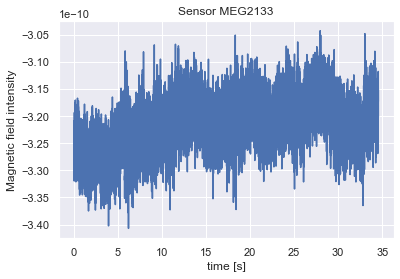

In [23]:
plt.plot(raw[0][1], raw[0][0][0])
plt.title(f'Sensor {sensor}')
plt.xlabel('time [s]')
plt.ylabel('Magnetic field intensity')
plt.show()

## Compute scale frequency relation

In [2]:
import numpy as np

In [5]:
jj = np.arange(1,20)

FjDo = fs*np.array([np.power(2.0,-j) for j in jj])
Fj = 3/4*FjDo
FjUp = 1/2*FjDo

In [6]:
Fj

array([7.50000000e+02, 3.75000000e+02, 1.87500000e+02, 9.37500000e+01,
       4.68750000e+01, 2.34375000e+01, 1.17187500e+01, 5.85937500e+00,
       2.92968750e+00, 1.46484375e+00, 7.32421875e-01, 3.66210938e-01,
       1.83105469e-01, 9.15527344e-02, 4.57763672e-02, 2.28881836e-02,
       1.14440918e-02, 5.72204590e-03, 2.86102295e-03])

In [16]:
FjDo

array([1.00000000e+03, 5.00000000e+02, 2.50000000e+02, 1.25000000e+02,
       6.25000000e+01, 3.12500000e+01, 1.56250000e+01, 7.81250000e+00,
       3.90625000e+00, 1.95312500e+00, 9.76562500e-01, 4.88281250e-01,
       2.44140625e-01, 1.22070312e-01, 6.10351562e-02, 3.05175781e-02,
       1.52587891e-02, 7.62939453e-03, 3.81469727e-03])

In [17]:
FjUp

array([5.00000000e+02, 2.50000000e+02, 1.25000000e+02, 6.25000000e+01,
       3.12500000e+01, 1.56250000e+01, 7.81250000e+00, 3.90625000e+00,
       1.95312500e+00, 9.76562500e-01, 4.88281250e-01, 2.44140625e-01,
       1.22070312e-01, 6.10351562e-02, 3.05175781e-02, 1.52587891e-02,
       7.62939453e-03, 3.81469727e-03, 1.90734863e-03])

## Second order Fourier-Wavelet analysis

In [29]:
data = raw[0][0][0]

In [30]:
data -= data.mean()
data /= data.std()

In [20]:
overlapingratio = 4
window_size = np.power(2, np.fix(np.log2(len(data))) - overlapingratio)

In [21]:
import mfanalysis.psd as psd

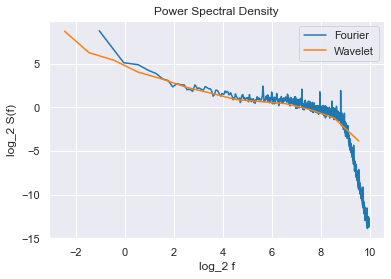

In [23]:
psd.plot_psd(data, fs, seg_size=window_size)

### Fitting the 1/f slope

In [24]:
import mfanalysis.fractal_analysis as fa

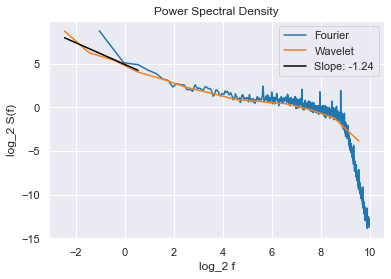

In [30]:
fa.plot_fractal(data, fs)

## Using the Signal class

In [25]:
import mfanalysis.signal as sig

In [26]:
S = sig.Signal(data, fs)

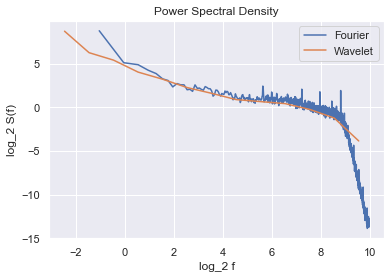

In [27]:
S.plot_psd()

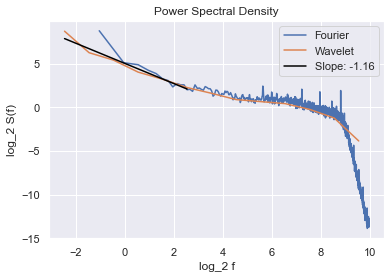

In [28]:
S.plot_fractal()

In [29]:
S.fractal_analysis()

FractalValues(beta=-1.1554283683096773, log_C=5.032327165260758, freq=array([[ 2.55074679],
       [ 1.55074679],
       [ 0.55074679],
       [-0.44925321],
       [-1.44925321],
       [-2.44925321]]))

## Second order Wavelet analysis using MF toolbox

In [26]:
import mfanalysis.mf_analysis as mf

In [32]:
nwt = 2

In [34]:
sf, cum, mfs = mf.mf_analysis_full(data,
    wt_name=f'db{nwt}',
    j1=10, j2=13,
    q=np.arange(-2,3),
    n_cumul=2,
    gamint=1/2,
    weighted=False
)

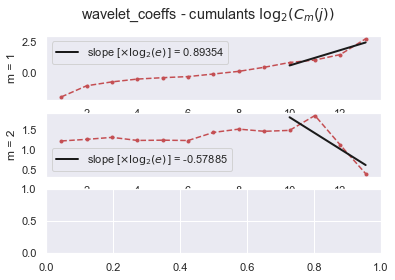

In [43]:
cum.plot()

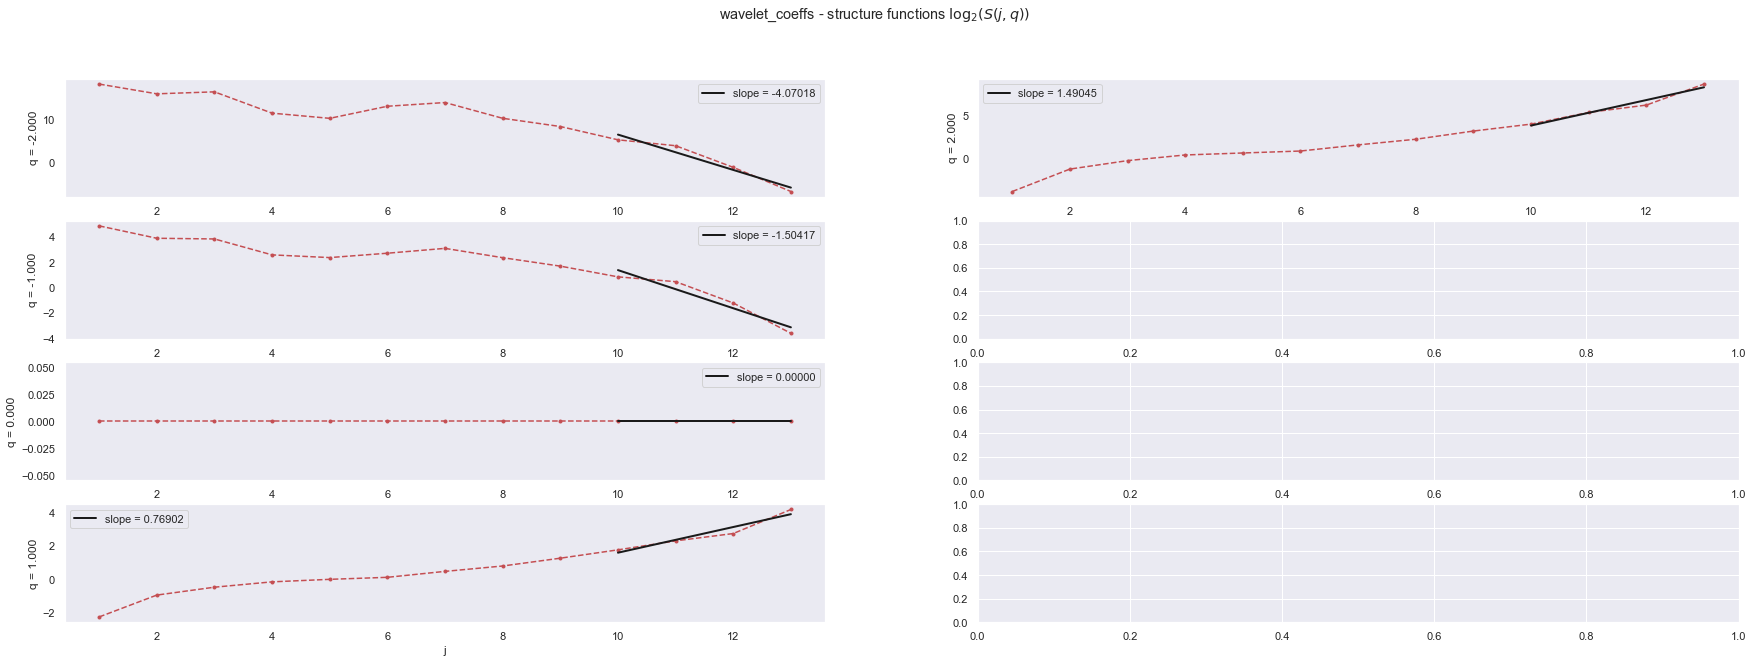

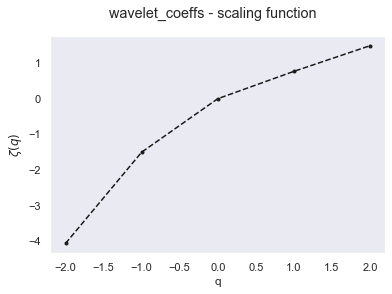

In [44]:
sf.plot()

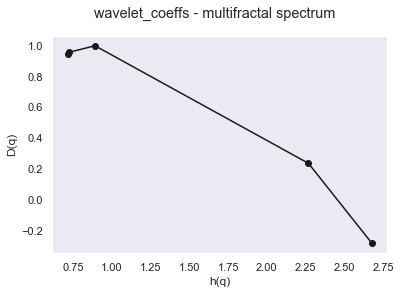

In [45]:
mfs.plot()

### Comparing results

Values are found in the logstat variable, optionally output by the MF_BS_tool `analyze` method call

The matrix of interest is logstat.('DWT').est ; the moments are found in the first 4 rows, whereas the cumulants are the last two

**Moments**

In [44]:
logmoment_matlab = np.genfromtxt(fname="/volatile/dumeur/Multifracs/MATLAB_values/logscale_moment_DWT.tsv", delimiter="\t", skip_header=0, filling_values=1)

In [46]:
logmoment_python = sf.logvalues

In [47]:
(np.abs(logmoment_matlab - logmoment_python) < 2.1e-5).all()

True

**Cumulants**

In [48]:
logcumulant_matlab = np.genfromtxt(fname="/volatile/dumeur/Multifracs/MATLAB_values/logscale_cumulant_DWT.tsv", delimiter="\t", skip_header=0, filling_values=1)

In [50]:
logcumulant_python = cum.values

In [51]:
(np.abs(logcumulant_matlab - logcumulant_python) < 7.3e-6).all()

True

## Univariate MF analysis

In [24]:
l = np.logspace(np.log10(0.01), np.log10(5), 10)
q = np.array([*-l, *l, 0, 1, 2, -1, -2])
q.sort()

In [33]:
sf, cum, mfs = mf.mf_analysis_full(data,
    wt_name=f'db{nwt}',
    j1=9, j2=12,
    q=q,
    n_cumul=3,
    gamint=1/2,
    weighted=False,
    p_exp=2
)

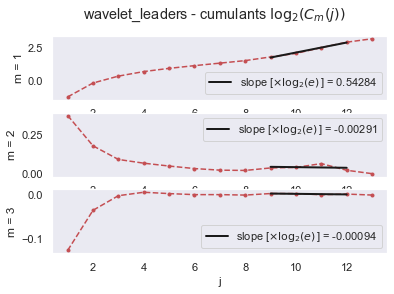

In [34]:
cum.plot()

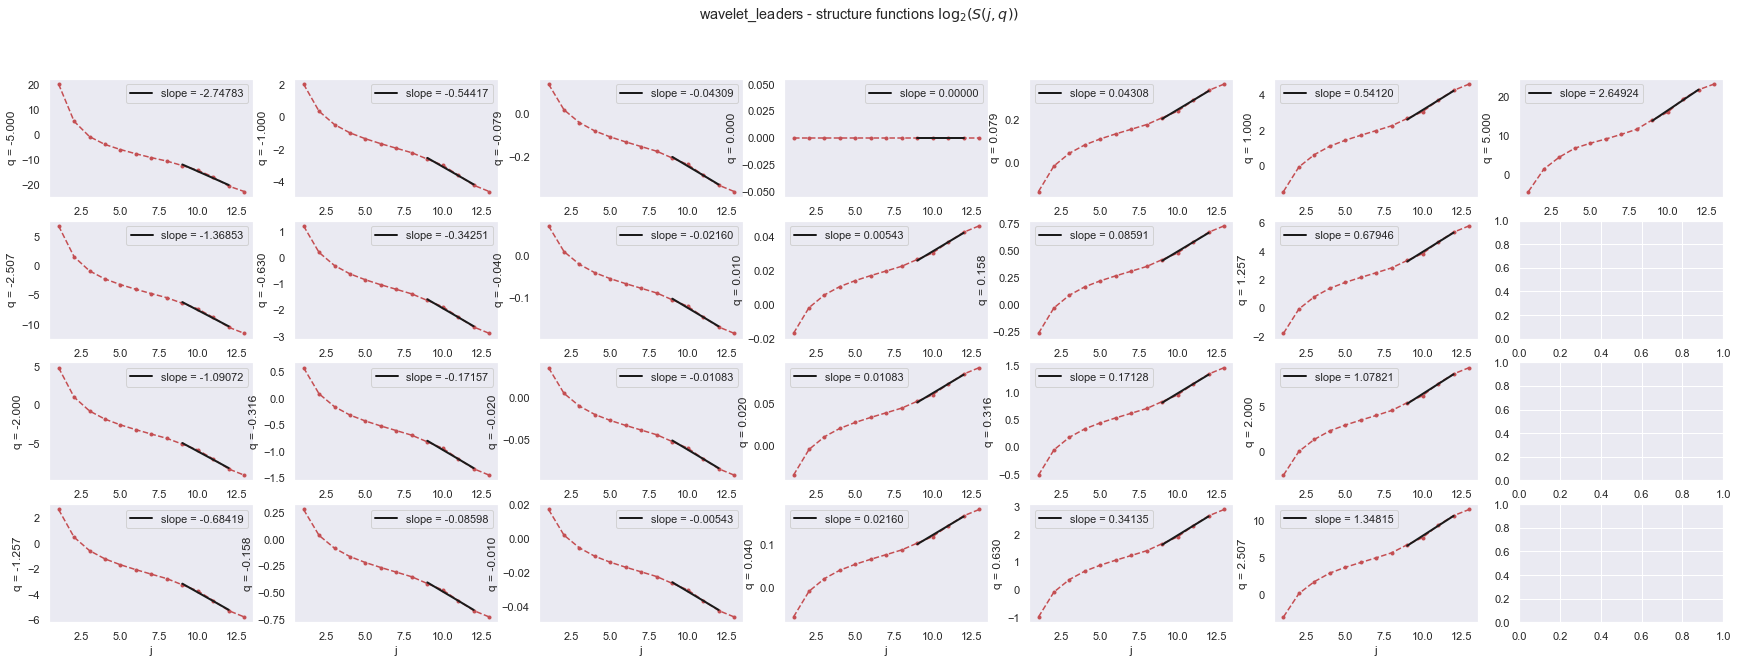

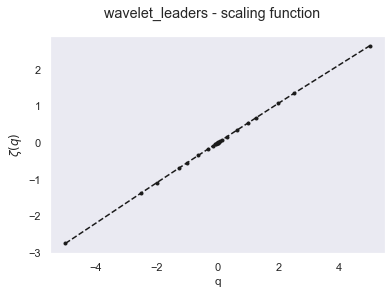

In [35]:
sf.plot()

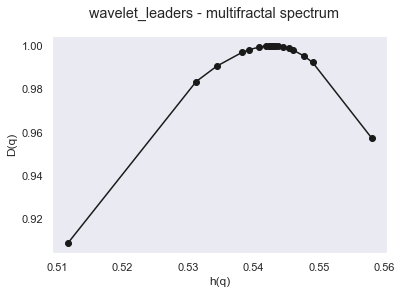

In [36]:
mfs.plot()

Comparing the multifractal spectre

In [67]:
D_matlab = np.genfromtxt(fname="/volatile/dumeur/Multifracs/MATLAB_values/D_LWT.tsv", delimiter="\t", skip_header=0, filling_values=1)
h_matlab = np.genfromtxt(fname="/volatile/dumeur/Multifracs/MATLAB_values/h_LWT.tsv", delimiter="\t", skip_header=0, filling_values=1)

In [69]:
h_python = mfs.hq
D_python = mfs.Dq

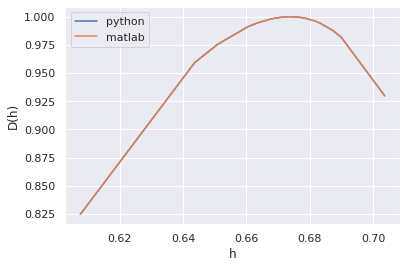

In [70]:
plt.plot(h_python, D_python)
plt.plot(h_matlab, D_matlab)
plt.legend(['python','matlab'])
plt.xlabel('h')
plt.ylabel('D(h)')
plt.show()

In [71]:
(np.abs(D_python - D_matlab) < 1e-12).all()

True

## Using the Signal class

In [46]:
import mfanalysis.signal as sig

In [47]:
S = sig.Signal(data, fs)

In [48]:
sf, cum, mfs = S.mf_analysis_full(j1=10, j2=14,
    wt_name=f'db{nwt}',
    q=q,
    n_cumul=3,
    gamint=1/2,
    weighted=False,
    p_exp=2)

In [49]:
S.hurst()

(0.7452242127347133,
 array([-3.85767434, -1.2349907 , -0.2464559 ,  0.41573373,  0.64719819,
         0.87649808,  1.59429037,  2.25357238,  3.21258854,  4.02473479,
         5.3942114 ,  6.24912533,  8.7079249 ]))

In [50]:
S.hmin()

(0.5324884486739828, -2.029468013676733)

# Wavelet leader version (p = $+\infty$)

In [51]:
l = np.logspace(np.log10(0.01), np.log10(5), 10)
q = np.array([*-l, *l, 0, 1, 2, -1, -2])
q.sort()

In [52]:
sf, cum, mfs = mf.mf_analysis_full(data,
    wt_name=f'db{nwt}',
    j1=10, j2=14,
    q=q,
    n_cumul=3,
    gamint=1/2,
    weighted=False,
    p_exp=np.inf
)

/home/dumeur/Multifracs/mfanalysis/mfanalysis/wavelet.py:76: UserWarning: Value of j2 is higher than the maximum allowed level. Max level and j2 set to 13
  warnings.warn("Value of j2 is higher than the maximum allowed level. "


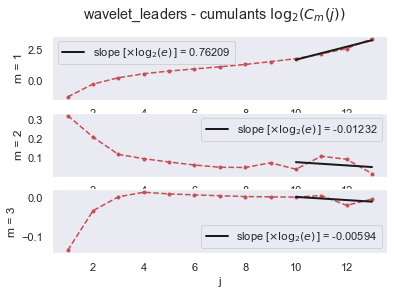

In [53]:
cum.plot()

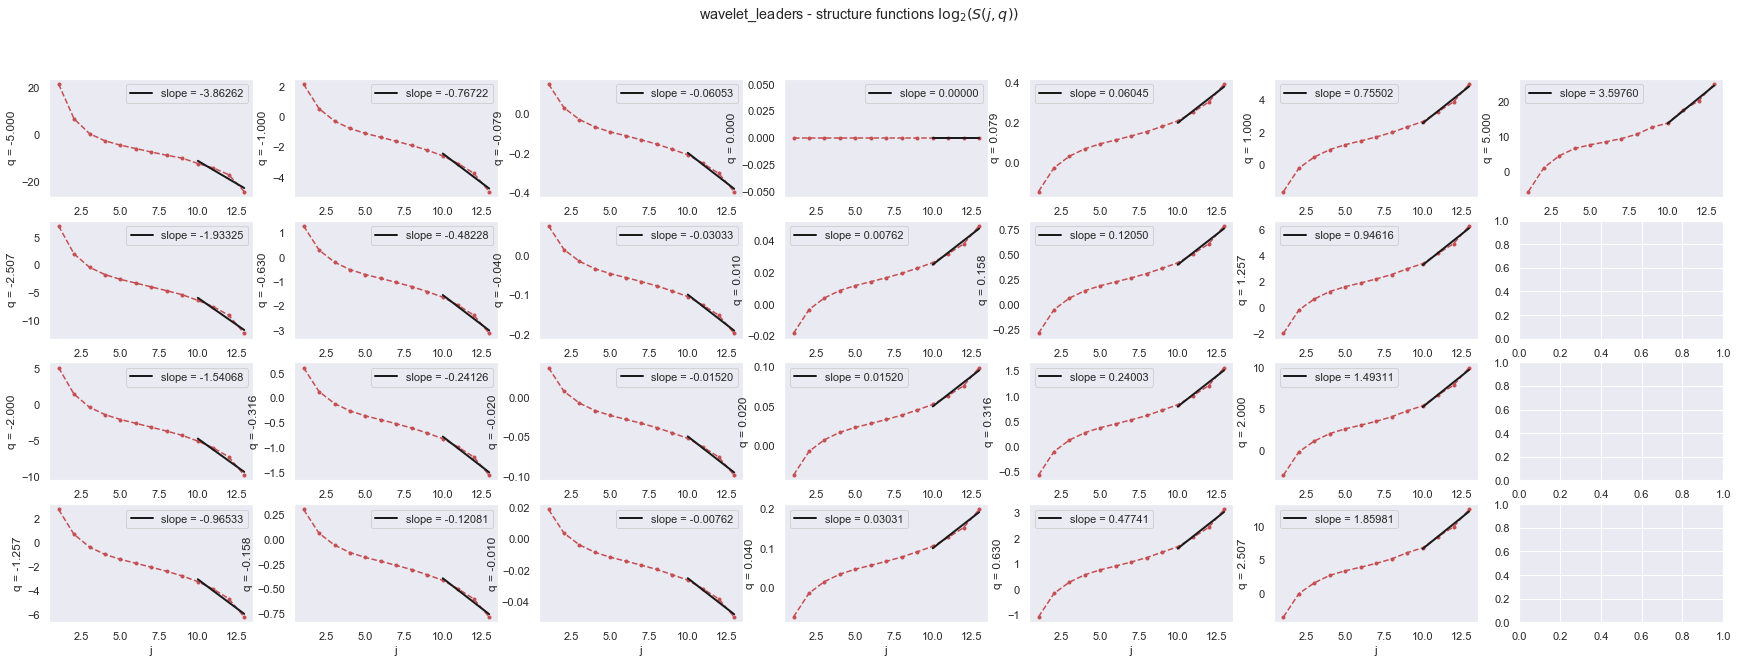

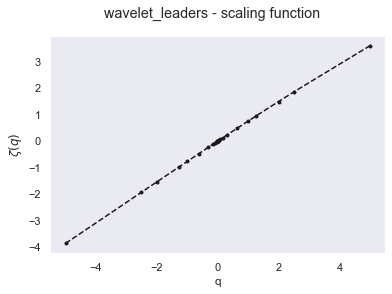

In [54]:
sf.plot()

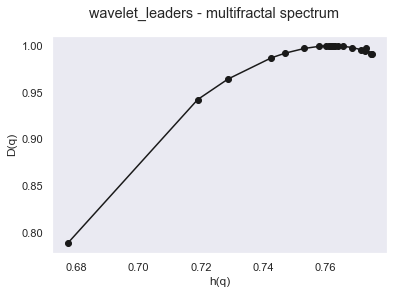

In [55]:
mfs.plot()

Comparing the MATLAB and python values for $\zeta(q)$

The values are found in `est.LWT.t`